In [135]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from scipy.stats import boxcox
from sklearn import tree


s3= boto3.resource('s3')
bucket_name= 'morgan-gant-data448-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'train.csv'
file_key2= 'test.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')
bucket_object2= bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

#reading the datefile
train = pd.read_csv(file_content_stream)
test = pd.read_csv(file_content_stream2)

In [4]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemsVoids,scansWithoutRegistration,quanitityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


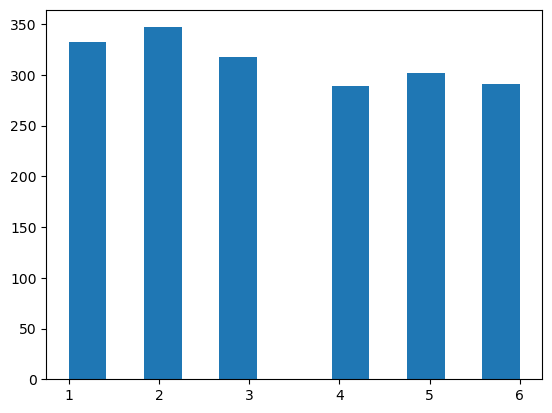

In [123]:
plt.hist(x=train['trustLevel'], bins=12)
plt.show()
#slightly sloped right

In [46]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,2.354358,467.0,88.48,4,8,4,0.014989,0.189465,0.571429
1,1.660831,1004.0,58.99,7,6,1,0.026892,0.058755,0.259259
2,0.000000,162.0,14.00,4,5,4,0.006173,0.086420,4.000000
3,2.998293,532.0,84.79,9,3,4,0.026316,0.159380,0.642857
4,2.998293,890.0,42.16,4,0,0,0.021348,0.047371,0.210526


In [136]:
#Engineering variables
#Variable 1: Box Cox on scannedLineItemsPerSecond
transformed_trustLevel= boxcox(train['trustLevel'])
train['trustLevel'] = transformed_grandTotal[0]

transformed_trustLevel= boxcox(test['trustLevel'])
test['trustLevel'] = transformed_trustLevel[0]

In [137]:
##Engineering variables
#2: Log base 10
train['log_grandTotal'] = np.log10(train['grandTotal'])

test['log_grandTotal'] = np.log10(test['grandTotal'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [138]:
##Engineering variables
#3: x^2
train['squared_valuePerSecond']= np.square(train['valuePerSecond'])

test['squared_valuePerSecond']= np.square(test['valuePerSecond'])

In [139]:
##Engineering variables
#4: 1/x
train['1_scannedLineItemsPerSecond']= 1/(train['scannedLineItemsPerSecond'])

test['1_scannedLineItemsPerSecond']= 1/(test['scannedLineItemsPerSecond'])

In [140]:
##Engineering variables
#5: x^3
train['cubed_lineItemVoidsPerPosition']= np.power(train['lineItemVoidsPerPosition'], 3)

test['cubed_lineItemVoidsPerPosition']= np.power(test['lineItemVoidsPerPosition'], 3)


In [141]:
##Engineering variables
#6: Natural Log
train['NL_totalScanTimeInSeconds']= np.log(train['totalScanTimeInSeconds'])

test['NL_totalScanTimeInSeconds']= np.log(test['totalScanTimeInSeconds'])


In [142]:
##Engineering variables
#7: Differencce
train['VPS_SLIPS']= train['valuePerSecond'] - train['scannedLineItemsPerSecond']

test['VPS_SLIPS']= train['valuePerSecond'] - train['scannedLineItemsPerSecond']

Random Forest Importance Selector

In [101]:
importances= list()
for i in range (1,100):
    # Defining the input and target variables
    x= train.drop(columns= 'fraud', axis=1)
    y= train['fraud']

    #Splitting the data
    x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

    #Building Model
    RF_md= RandomForestClassifier(n_estimators= 500, max_depth=3).fit(x_train, y_train)
    #Extracting the feature importances
    importances.append(RF_md.feature_importances_)

In [102]:
#Computing averages of features
rf = pd.DataFrame(importances)
rf.columns= ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemsVoids', 'scansWithoutRegistration', 'quanitityModification', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'log_grandTotal', 'squared_valuePerSecond', '1_scannedLineItemsPerSecond', 'cubed_lineItemVoidsPerPosition', 'NL_totalScanTimeInSeconds', 'VPS_SLIPS']
rf.apply(np.mean, axis = 0)

trustLevel                        0.046329
totalScanTimeInSeconds            0.105832
grandTotal                        0.045803
lineItemsVoids                    0.051840
scansWithoutRegistration          0.027196
quanitityModification             0.004179
scannedLineItemsPerSecond         0.125886
valuePerSecond                    0.047922
lineItemVoidsPerPosition          0.071777
log_grandTotal                    0.046892
squared_valuePerSecond            0.048429
1_scannedLineItemsPerSecond       0.125897
cubed_lineItemVoidsPerPosition    0.073256
NL_totalScanTimeInSeconds         0.106825
VPS_SLIPS                         0.071937
dtype: float64

In [143]:
#Engineering interactions based on feature importance
train['interaction_1']= train['trustLevel'] * train['totalScanTimeInSeconds']
train['interaction_2']= train['trustLevel'] * train['lineItemsVoids']
train['interaction_3']= train['totalScanTimeInSeconds'] * train['lineItemsVoids']


test['interaction_1']= test['trustLevel'] * test['totalScanTimeInSeconds']
test['interaction_2']= test['trustLevel'] * test['lineItemVoids']
test['interaction_3']= test['totalScanTimeInSeconds'] * test['lineItemVoids']

[Text(0.6666666666666666, 0.875, 'interaction_1 <= 62851.318\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.5, 0.625, '1_scannedLineItemsPerSecond <= 85.555\ngini = 0.101\nsamples = 1500\nvalue = [1420, 80]'),
 Text(0.3333333333333333, 0.375, 'NL_totalScanTimeInSeconds <= 7.215\ngini = 0.152\nsamples = 967\nvalue = [887, 80]'),
 Text(0.16666666666666666, 0.125, 'gini = 0.098\nsamples = 815\nvalue = [773, 42]'),
 Text(0.5, 0.125, 'gini = 0.375\nsamples = 152\nvalue = [114, 38]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 533\nvalue = [533, 0]'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

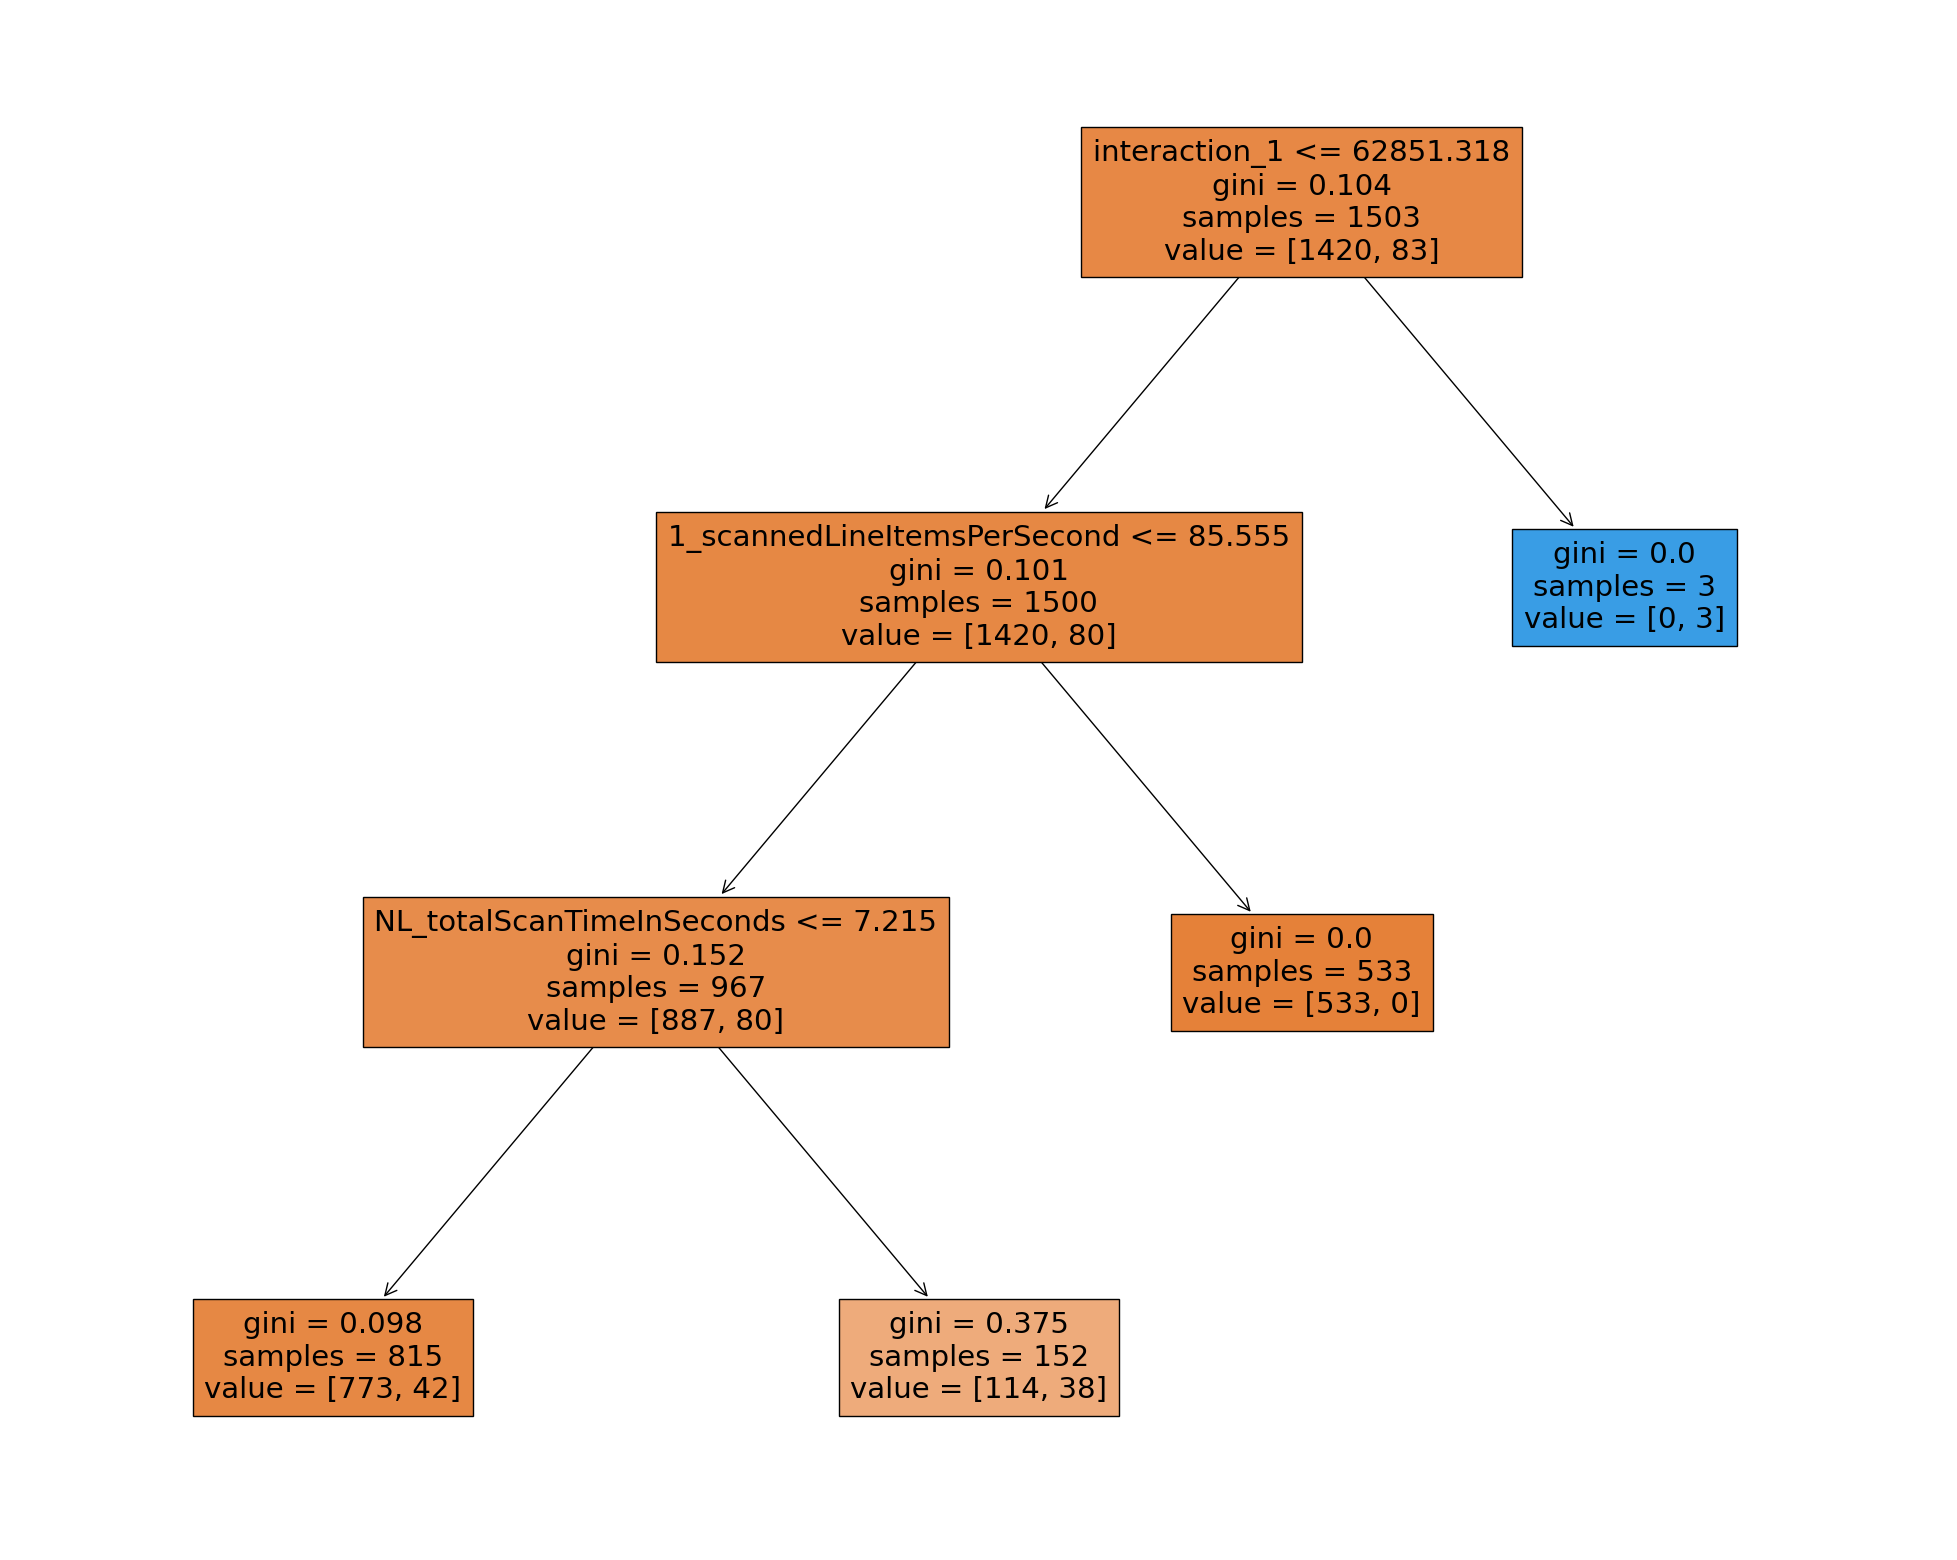

In [144]:
#1
# Defining the input and target variables
x= train.drop(columns= 'fraud', axis=1)
y= train['fraud']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

[Text(0.5, 0.875, 'scannedLineItemsPerSecond <= 0.015\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.25, 0.625, 'totalScanTimeInSeconds <= 1829.5\ngini = 0.02\nsamples = 679\nvalue = [672, 7]'),
 Text(0.125, 0.375, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.018\nsamples = 677\nvalue = [671, 6]'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 520\nvalue = [520, 0]'),
 Text(0.1875, 0.125, 'gini = 0.074\nsamples = 157\nvalue = [151, 6]'),
 Text(0.375, 0.375, 'totalScanTimeInSeconds <= 1830.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.75, 0.625, 'totalScanTimeInSeconds <= 1297.0\ngini = 0.167\nsamples = 824\nvalue = [748, 76]'),
 Text(0.625, 0.375, 'totalScanTimeInSeconds <= 299.5\ngini = 0.109\nsamples = 710\nvalue = [669, 41]'),
 Text(0.5625, 0.125, 'gini = 0.009\nsamples = 232\nvalue = [231, 1]'),
 Text(0.6875, 0.125, 'gini = 0.153\nsa

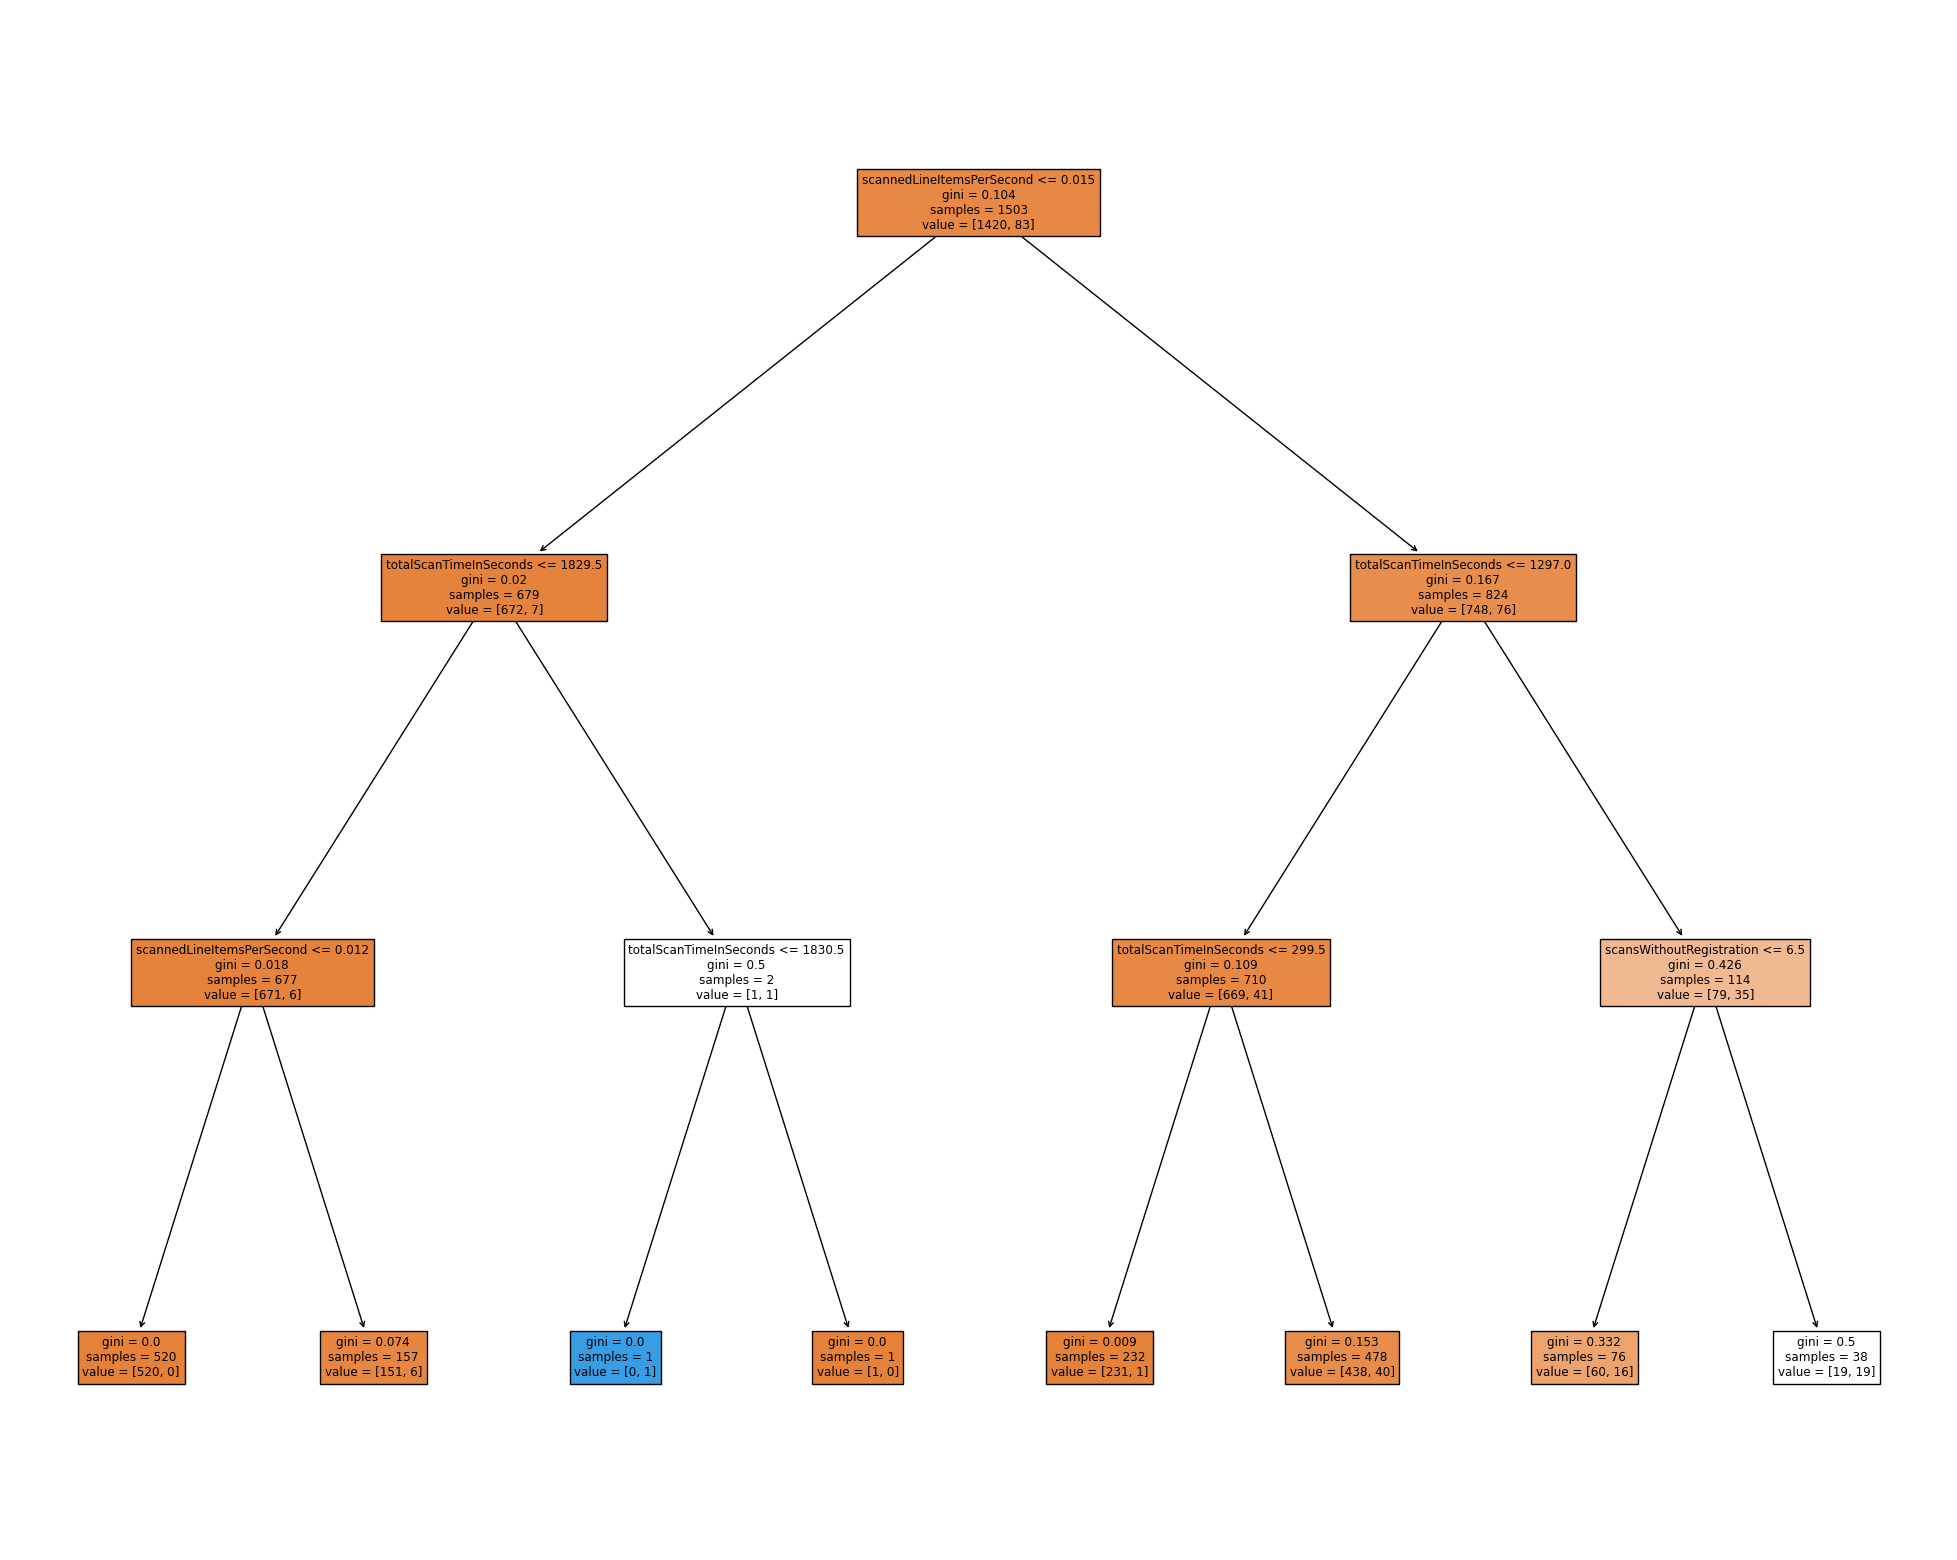

In [127]:
#2
# Defining the input and target variables
x= train.drop(columns= 'fraud', axis=1)
y= train['fraud']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

[Text(0.375, 0.875, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 533\nvalue = [533, 0]'),
 Text(0.5, 0.625, 'totalScanTimeInSeconds <= 1483.5\ngini = 0.156\nsamples = 970\nvalue = [887, 83]'),
 Text(0.25, 0.375, 'valuePerSecond <= 0.115\ngini = 0.117\nsamples = 867\nvalue = [813, 54]'),
 Text(0.125, 0.125, 'gini = 0.163\nsamples = 547\nvalue = [498, 49]'),
 Text(0.375, 0.125, 'gini = 0.031\nsamples = 320\nvalue = [315, 5]'),
 Text(0.75, 0.375, 'totalScanTimeInSeconds <= 1818.0\ngini = 0.405\nsamples = 103\nvalue = [74, 29]'),
 Text(0.625, 0.125, 'gini = 0.38\nsamples = 98\nvalue = [73, 25]'),
 Text(0.875, 0.125, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]')]

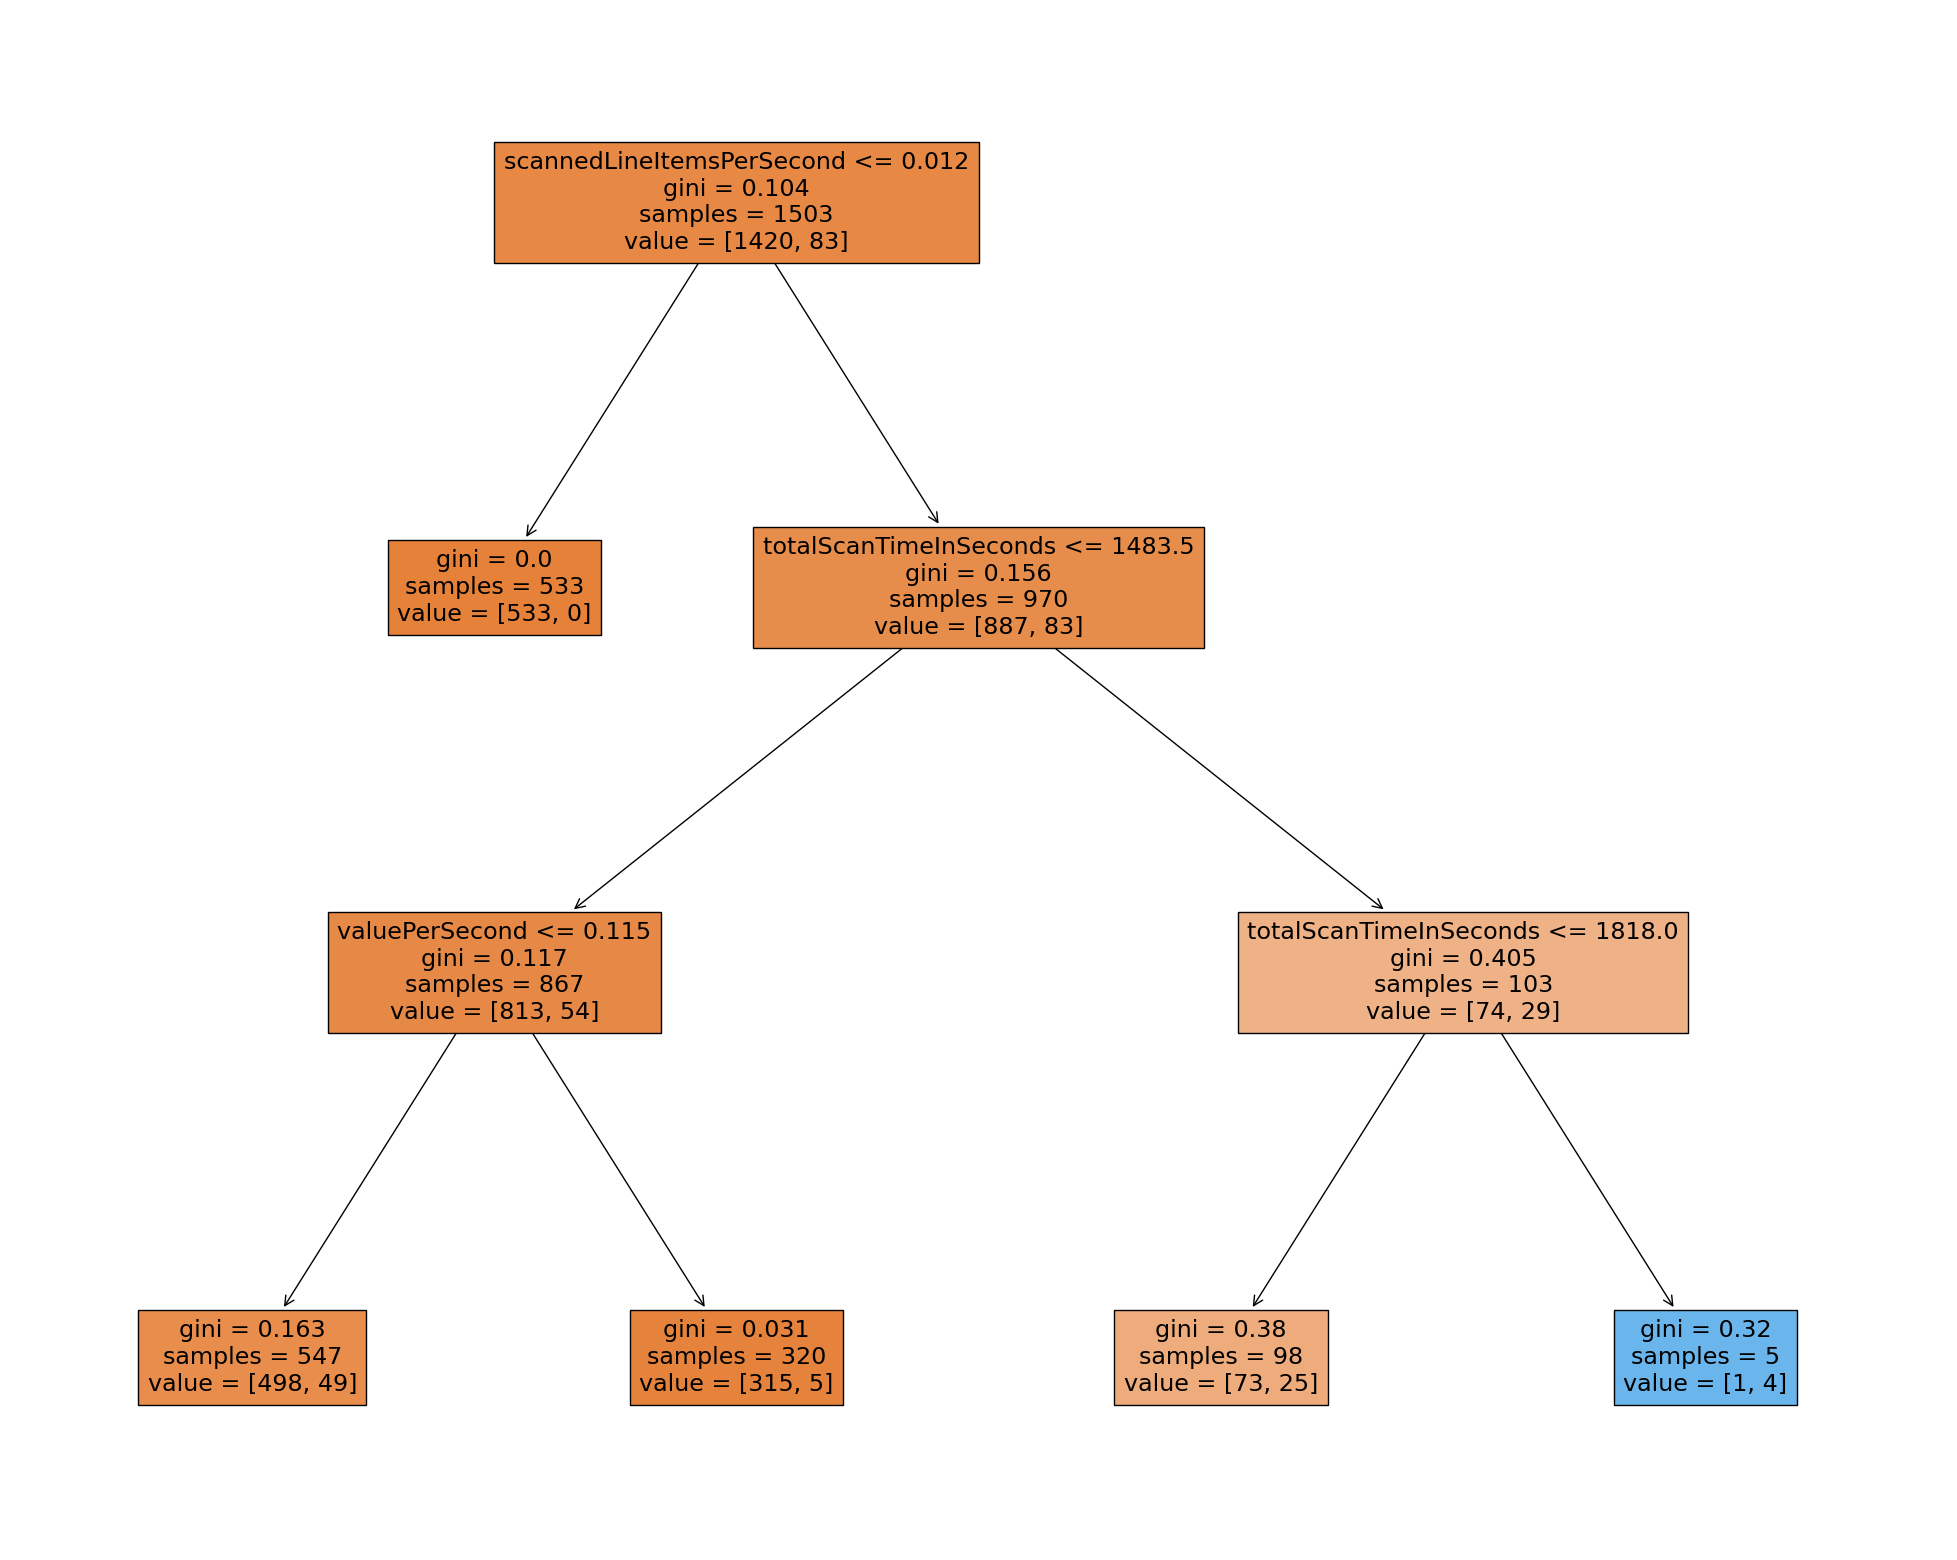

In [128]:
#3
# Defining the input and target variables
x= train.drop(columns= 'fraud', axis=1)
y= train['fraud']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

In [134]:
#engineering features from the decisoon tree model
train['interaction_4']=np.where((train['scannedLineItemsPerSecond'] <= .012) &
                                   (train['totalScanTimeInSeconds'] > 299.5), 1, 0)
                                 
train['interaction_5']=np.where(((train['scannedLineItemsPerSecond'] <= .015) &
                                   (train['totalScanTimeInSeconds'] <= 1829.5) &
                                (train['scannedLineItemsPerSecond'] <= .012)), 1, 0)
        
train['interaction_6']=np.where(((train['scannedLineItemsPerSecond'] <= .015) &
                                   (train['totalScanTimeInSeconds'] <= 1829.5) &
                                (train['valuePerSecond'] <= .115)), 1, 0)


#engineering features from the decisoon tree model
test['interaction_4']=np.where((test['scannedLineItemsPerSecond'] <= .012) &
                                   (test['totalScanTimeInSeconds'] > 299.5), 1, 0)
                                 
test['interaction_5']=np.where(((test['scannedLineItemsPerSecond'] <= .015) &
                                   (test['totalScanTimeInSeconds'] <= 1829.5) &
                                (test['scannedLineItemsPerSecond'] <= .012)), 1, 0)
        
test['interaction_6']=np.where(((test['scannedLineItemsPerSecond'] <= .015) &
                                   (test['totalScanTimeInSeconds'] <= 1829.5) &
                                (test['valuePerSecond'] <= .115)), 1, 0)